# Denoising scRNA-seq using DCA

## REPURPOSED!

## Initial Pulling

In [1]:
!git clone https://github.com/theislab/dca.git
!mv dca dca_master

Cloning into 'dca'...
remote: Enumerating objects: 2879, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 2879 (delta 49), reused 39 (delta 17), pack-reused 2792
Receiving objects: 100% (2879/2879), 607.33 MiB | 33.91 MiB/s, done.
Resolving deltas: 100% (1646/1646), done.


In [2]:
!cp -r dca_master/dca dca
!cp -r dca_master/setup.py setup.py
!cp dca_master/reproducibility/download.sh download.sh

In [3]:
# # Refresh my DCA because you need to do some preprocessing :)
# !rm -r dca
# !cp -r dca_master/dca dca

In [4]:
!bash download.sh

--2021-12-14 05:12:43--  https://hmgubox.helmholtz-muenchen.de/f/1a014dc377f64b2b964c/?dl=1
Resolving hmgubox.helmholtz-muenchen.de (hmgubox.helmholtz-muenchen.de)... 146.107.6.220
Connecting to hmgubox.helmholtz-muenchen.de (hmgubox.helmholtz-muenchen.de)|146.107.6.220|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://hmgubox.helmholtz-muenchen.de/seafhttp/files/18fb360d-f8a4-4dee-aa73-7fd06da71ee5/dca_datasets.zip [following]
--2021-12-14 05:12:44--  https://hmgubox.helmholtz-muenchen.de/seafhttp/files/18fb360d-f8a4-4dee-aa73-7fd06da71ee5/dca_datasets.zip
Reusing existing connection to hmgubox.helmholtz-muenchen.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 756725696 (722M) [application/zip]
Saving to: ‘datasets.zip’

datasets.zip        100%[===================>] 721.67M  26.6MB/s    in 28s     

2021-12-14 05:13:12 (25.9 MB/s) - ‘datasets.zip’ saved [756725696/756725696]

Archive:  ../datasets.zip
   creating: chu/
  inflating: 

## Additional Repo Preprocessing and Imports

In [5]:
!pip install --upgrade pip
!pip uninstall  -y tensorflow keras
!pip install -q tensorflow==2.4.0 keras==2.4.0 scanpy kopt

     |████████████████████████████████| 1.7 MB 5.1 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Found existing installation: tensorflow 2.7.0
Uninstalling tensorflow-2.7.0:
  Successfully uninstalled tensorflow-2.7.0
Found existing installation: keras 2.7.0
Uninstalling keras-2.7.0:
  Successfully uninstalled keras-2.7.0
     |████████████████████████████████| 394.7 MB 17 kB/s              
     |████████████████████████████████| 170 kB 54.4 MB/s            
     |████████████████████████████████| 2.0 MB 58.1 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 462 kB 51.0 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 2.9 MB 43.4 MB/s            
     |████████████████████████████████| 3.8 MB 46.3 MB/s            
     |████████████████████████████████| 86 kB 6.3 MB/s             
  Prepa

In [6]:
import os

switches = {
    "from keras.engine.topology import Layer": "from keras.layers import Layer, InputSpec",
    "from keras.engine.base_layer import InputSpec" : "",
    "from keras.objectives import mean_squared_error" : "from keras.metrics import mean_squared_error",
    "import keras.optimizers as opt" : "import tensorflow.keras.optimizers as opt"
}

def replace_and_log(line, val1, val2):
    out = line.replace(val1, val2)
    print(f' - {line} + {out}')
    return out


dirct = 'dca'
for fname in os.listdir(dirct):
    if fname.endswith(".py"):
        fpath = os.path.join(dirct, fname)
        print(f"Handling {fpath}")
        data = ""
        with open(fpath, 'r') as fin: 
            for ln, line in enumerate(fin):
                lstrp = line.strip()
                if lstrp in switches.keys():
                    line = replace_and_log(line, lstrp, switches[lstrp])
                if 'from keras' in line: 
                    line = replace_and_log(line, 'from keras', 'from tensorflow.keras')
                data += line
        with open(fpath, 'w') as fout: 
            fout.write(data)

Handling dca/hyper.py
 - import keras.optimizers as opt
 + import tensorflow.keras.optimizers as opt

Handling dca/__init__.py
Handling dca/loss.py
 - from keras import backend as K
 + from tensorflow.keras import backend as K

Handling dca/layers.py
 - from keras.engine.topology import Layer
 + from keras.layers import Layer, InputSpec

 - from keras.layers import Layer, InputSpec
 + from tensorflow.keras.layers import Layer, InputSpec

 - from keras.layers import Lambda, Dense
 + from tensorflow.keras.layers import Lambda, Dense

 - from keras.engine.base_layer import InputSpec
 + 

 - from keras import backend as K
 + from tensorflow.keras import backend as K

Handling dca/network.py
 - from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Lambda
 + from tensorflow.keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Lambda

 - from keras.models import Model
 + from tensorflow.keras.models import Model

 - from keras.regularizers impor

In [7]:
# importlib.reload(tensorflow)
# importlib.reload(keras)
import keras
import tensorflow

print("Tensorflow :", tensorflow.__version__)
print("Keras      :", keras.__version__)
print("TF Keras   :", tensorflow.keras.__version__)

Tensorflow : 2.4.0
Keras      : 2.4.0
TF Keras   : 2.4.0


Using TensorFlow backend.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import importlib 
import pandas as pd

## API Imports
import os, tempfile, shutil, random
import anndata
from functools import partial

## scRNA-seq Simulation using Splatter R package and rpy2

In [9]:
# # make sure that rpy2 is installed: https://rpy2.bitbucket.io/
# %load_ext rpy2.ipython

# import warnings
# from rpy2.rinterface import RRuntimeWarning

# # ignore R warning messages
# warnings.filterwarnings("ignore", category=RRuntimeWarning)

In [10]:
# %%R 
# if (!requireNamespace("BiocManager", quietly = TRUE)) {
#     cat("Intalling 'BiocManager'\n")
#     install.packages("BiocManager", quiet=TRUE)
# }
# cat("Intalling 'splatter'\n")
# BiocManager::install("splatter", ask=FALSE, verbose=FALSE, quiet=TRUE)

### Simulate two groups using Splatter

In [11]:
# %%R
# # make sure that splatter is installed: https://github.com/Oshlack/splatter
# library(splatter)

# simulate <- function(nGroups=2, nGenes=200, batchCells=2000, dropout=3)
# {
#     if (nGroups > 1) method <- 'groups'
#     else             method <- 'single'

#     group.prob <- rep(1, nGroups) / nGroups

#     # new splatter requires dropout.type
#     if ('dropout.type' %in% slotNames(newSplatParams())) {
#         if (dropout)
#             dropout.type <- 'experiment'
#         else
#             dropout.type <- 'none'
        
#         sim <- splatSimulate(group.prob=group.prob, nGenes=nGenes, batchCells=batchCells,
#                              dropout.type=dropout.type, method=method,
#                              seed=42, dropout.shape=-1, dropout.mid=dropout)

#     } else {
#         sim <- splatSimulate(group.prob=group.prob, nGenes=nGenes, batchCells=batchCells,
#                              dropout.present=!dropout, method=method,
#                              seed=42, dropout.shape=-1, dropout.mid=dropout)        
#     }

#     counts     <- as.data.frame(t(counts(sim)))
#     truecounts <- as.data.frame(t(assays(sim)$TrueCounts))

#     dropout    <- assays(sim)$Dropout
#     # mode(dropout) <- 'integer'  ## Causes issues

#     cellinfo   <- as.data.frame(colData(sim))
#     geneinfo   <- as.data.frame(rowData(sim))

#     list(counts=counts,
#          cellinfo=cellinfo,
#          geneinfo=geneinfo,
#          truecounts=truecounts)
# }

In [12]:
# %%R -o counts -o truecounts -o geneinfo -o cellinfo
# sim <- simulate()

# counts     <- sim$counts
# geneinfo   <- sim$geneinfo
# cellinfo   <- sim$cellinfo
# truecounts <- sim$truecounts

In [13]:
# !mkdir -p sim_data/{data1,data2}

In [14]:
# counts.to_csv('sim_data/data1/counts.csv')
# truecounts.to_csv('sim_data/data1/truecounts.csv')
# geneinfo.to_csv('sim_data/data1/geneinfo.csv')
# cellinfo.to_csv('sim_data/data1/cellinfo.csv')

### Simulating 6 groups

In [15]:
# %%R -o counts -o geneinfo -o cellinfo -o truecounts

# sim <- simulate(nGroups=6, dropout=1)

# counts     <- sim$counts
# geneinfo   <- sim$geneinfo
# cellinfo   <- sim$cellinfo
# truecounts <- sim$truecounts

In [16]:
# counts.to_csv(        'sim_data/data2/counts.csv')
# truecounts.to_csv(    'sim_data/data2/truecounts.csv')
# geneinfo.to_csv(      'sim_data/data2/geneinfo.csv')
# cellinfo.to_csv(      'sim_data/data2/cellinfo.csv')

### Final zip-up of r simulations (because R library takes forever to download in colab)

In [17]:
# !rm -rf sim_data/.ipynb_checkpoints/
# !zip -r sim_data.zip sim_data

### Just Download The Cache Instead!

In [18]:
!gdown https://drive.google.com/uc?id=1IU-Y8ygWeQ-r-ZpBLcwgIb3kycx2Xsw5
!unzip sim_data.zip

Downloading...
From: https://drive.google.com/uc?id=1IU-Y8ygWeQ-r-ZpBLcwgIb3kycx2Xsw5
To: /content/sim_data.zip
100% 2.16M/2.16M [00:00<00:00, 67.0MB/s]
Archive:  sim_data.zip
   creating: sim_data/
   creating: sim_data/data1/
  inflating: sim_data/data1/truecounts.csv  
  inflating: sim_data/data1/geneinfo.csv  
  inflating: sim_data/data1/counts.csv  
  inflating: sim_data/data1/cellinfo.csv  
   creating: sim_data/data2/
  inflating: sim_data/data2/truecounts.csv  
  inflating: sim_data/data2/geneinfo.csv  
  inflating: sim_data/data2/counts.csv  
  inflating: sim_data/data2/cellinfo.csv  
   creating: sim_data/.ipynb_checkpoints/


## network.py : MODIFY ME

### Existing Codebase

#### Prelude

In [19]:
# Copyright 2016 Goekcen Eraslan
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

import pickle
from abc import ABCMeta, abstractmethod

import keras
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1_l2
# from tensorflow.keras.objectives import mean_squared_error
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.keras.initializers import Constant
from tensorflow.keras import backend as K

import tensorflow as tf

from dca.loss import poisson_loss, NB, ZINB
from dca.layers import ConstantDispersionLayer, SliceLayer, ColwiseMultLayer, ElementwiseDense
from dca.io import write_text_matrix


MeanAct = lambda x: tf.clip_by_value(K.exp(x), 1e-5, 1e6)
DispAct = lambda x: tf.clip_by_value(tf.nn.softplus(x), 1e-4, 1e4)

advanced_activations = ('PReLU', 'LeakyReLU')

#### Basic Autoencoders

In [20]:
class Autoencoder():
    def __init__(self,
                 input_size,
                 output_size=None,
                 hidden_size=(64, 32, 64),
                 l2_coef=0.,
                 l1_coef=0.,
                 l2_enc_coef=0.,
                 l1_enc_coef=0.,
                 ridge=0.,
                 hidden_dropout=0.,
                 input_dropout=0.,
                 batchnorm=True,
                 activation='relu',
                 init='glorot_uniform',
                 file_path=None,
                 debug=False):

        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.l2_coef = l2_coef
        self.l1_coef = l1_coef
        self.l2_enc_coef = l2_enc_coef
        self.l1_enc_coef = l1_enc_coef
        self.ridge = ridge
        self.hidden_dropout = hidden_dropout
        self.input_dropout = input_dropout
        self.batchnorm = batchnorm
        self.activation = activation
        self.init = init
        self.loss = None
        self.file_path = file_path
        self.extra_models = {}
        self.model = None
        self.encoder = None
        self.decoder = None
        self.input_layer = None
        self.sf_layer = None
        self.debug = debug

        if self.output_size is None:
            self.output_size = input_size

        if isinstance(self.hidden_dropout, list):
            assert len(self.hidden_dropout) == len(self.hidden_size)
        else:
            self.hidden_dropout = [self.hidden_dropout]*len(self.hidden_size)

    def build(self):

        self.input_layer = Input(shape=(self.input_size,), name='count')
        self.sf_layer = Input(shape=(1,), name='size_factors')
        last_hidden = self.input_layer

        if self.input_dropout > 0.0:
            last_hidden = Dropout(self.input_dropout, name='input_dropout')(last_hidden)

        for i, (hid_size, hid_drop) in enumerate(zip(self.hidden_size, self.hidden_dropout)):
            center_idx = int(np.floor(len(self.hidden_size) / 2.0))
            if   i == center_idx:   layer_name, stage = 'center', 'center'
            elif i  < center_idx:   layer_name, stage = 'enc%s' % i, 'encoder'
            else:                   layer_name, stage = 'dec%s' % (i-center_idx), 'decoder'

            # use encoder-specific l1/l2 reg coefs if given
            use_l1_coeff = self.l1_enc_coef != 0. and stage in ('center', 'encoder')
            use_l2_coeff = self.l2_enc_coef != 0. and stage in ('center', 'encoder')
            l1 = self.l1_enc_coef if use_l1_coeff else self.l1_coef
            l2 = self.l2_enc_coef if use_l2_coeff else self.l2_coef

            last_hidden = Dense(hid_size, activation=None, kernel_initializer=self.init,
                                kernel_regularizer=l1_l2(l1, l2),
                                name=layer_name)(last_hidden)
            if self.batchnorm:
                last_hidden = BatchNormalization(center=True, scale=False)(last_hidden)

            # Use separate act. layers to give user the option to get pre-activations
            # of layers when requested
            if self.activation in advanced_activations:
                last_hidden = keras.layers.__dict__[self.activation](name='%s_act'%layer_name)(last_hidden)
            else:
                last_hidden = Activation(self.activation, name='%s_act'%layer_name)(last_hidden)

            if hid_drop > 0.0:
                last_hidden = Dropout(hid_drop, name='%s_drop'%layer_name)(last_hidden)

        self.decoder_output = last_hidden
        self.build_output()

    def build_output(self):

        self.loss = mean_squared_error
        mean = Dense(self.output_size, kernel_initializer=self.init,
                     kernel_regularizer=l1_l2(self.l1_coef, self.l2_coef),
                     name='mean')(self.decoder_output)
        output = ColwiseMultLayer([mean, self.sf_layer])

        # keep unscaled output as an extra model
        self.extra_models['mean_norm'] = Model(inputs=self.input_layer, outputs=mean)
        self.extra_models['decoded'] = Model(inputs=self.input_layer, outputs=self.decoder_output)
        self.model = Model(inputs=[self.input_layer, self.sf_layer], outputs=output)

        self.encoder = self.get_encoder()

    def save(self):
        if self.file_path:
            os.makedirs(self.file_path, exist_ok=True)
            with open(os.path.join(self.file_path, 'model.pickle'), 'wb') as f:
                pickle.dump(self, f)

    def load_weights(self, filename):
        self.model.load_weights(filename)
        self.encoder = self.get_encoder()
        self.decoder = None  # get_decoder()

    def get_decoder(self):
        for i, l in enumerate(self.model.layers):
            if l.name == 'center_drop': break

        return Model(inputs  = self.model.get_layer(index=i+1).input,
                     outputs = self.model.output)

    def get_encoder(self, activation=False):
        out_layer = self.model.get_layer('center_act' if activation else 'center')
        return Model(inputs=self.model.input, outputs=out_layer.output)

    def predict(self, adata, mode='denoise', return_info=False, copy=False):

        assert mode in ('denoise', 'latent', 'full'), 'Unknown mode'
        adata = adata.copy() if copy else adata

        if mode in ('denoise', 'full'):
            print('dca: Calculating reconstructions...')
            adata.X = self.model.predict({'count': adata.X, 'size_factors': adata.obs.size_factors})
        if mode in ('latent', 'full'):
            print('dca: Calculating low dimensional representations...')
            adata.obsm['X_dca'] = self.encoder.predict({'count': adata.X, 'size_factors': adata.obs.size_factors})
        if mode == 'latent':
            adata.X = adata.raw.X.copy() #recover normalized expression values

        return adata if copy else None

    def write(self, adata, file_path, mode='denoise', colnames=None):

        colnames = adata.var_names.values if colnames is None else colnames
        rownames = adata.obs_names.values

        print('dca: Saving output(s)...')
        os.makedirs(file_path, exist_ok=True)

        if mode in ('denoise', 'full'):
            print('dca: Saving denoised expression...')
            write_text_matrix(adata.X,
                              os.path.join(file_path, 'mean.tsv'),
                              rownames=rownames, colnames=colnames, transpose=True)

        if mode in ('latent', 'full'):
            print('dca: Saving latent representations...')
            write_text_matrix(adata.obsm['X_dca'],
                              os.path.join(file_path, 'latent.tsv'),
                              rownames=rownames, transpose=False)

class PoissonAutoencoder(Autoencoder):

    def build_output(self):
        mean = Dense(self.output_size, activation=MeanAct, kernel_initializer=self.init,
                     kernel_regularizer=l1_l2(self.l1_coef, self.l2_coef),
                     name='mean')(self.decoder_output)
        output = ColwiseMultLayer([mean, self.sf_layer])
        self.loss = poisson_loss

        self.extra_models['mean_norm'] = Model(inputs=self.input_layer, outputs=mean)
        self.extra_models['decoded'] = Model(inputs=self.input_layer, outputs=self.decoder_output)
        self.model = Model(inputs=[self.input_layer, self.sf_layer], outputs=output)

        self.encoder = self.get_encoder()

#### NB-Autoencoders

In [21]:
class NBConstantDispAutoencoder(Autoencoder):

    def build_output(self):
        mean = Dense(self.output_size, activation=MeanAct, kernel_initializer=self.init,
                     kernel_regularizer=l1_l2(self.l1_coef, self.l2_coef),
                     name='mean')(self.decoder_output)

        # Plug in dispersion parameters via fake dispersion layer
        disp = ConstantDispersionLayer(name='dispersion')
        mean = disp(mean)

        output = ColwiseMultLayer([mean, self.sf_layer])

        nb = NB(disp.theta_exp)
        self.loss = nb.loss
        self.extra_models['dispersion'] = lambda :K.function([], [nb.theta])([])[0].squeeze()
        self.extra_models['mean_norm'] = Model(inputs=self.input_layer, outputs=mean)
        self.extra_models['decoded'] = Model(inputs=self.input_layer, outputs=self.decoder_output)
        self.model = Model(inputs=[self.input_layer, self.sf_layer], outputs=output)

        self.encoder = self.get_encoder()

    def predict(self, adata, mode='denoise', return_info=False, copy=False):
        colnames = adata.var_names.values
        rownames = adata.obs_names.values
        res = super().predict(adata, mode, return_info, copy)
        adata = res if copy else adata

        if return_info:
            adata.var['X_dca_dispersion'] = self.extra_models['dispersion']()

        return adata if copy else None

    def write(self, adata, file_path, mode='denoise', colnames=None):
        colnames = adata.var_names.values if colnames is None else colnames
        rownames = adata.obs_names.values

        super().write(adata, file_path, mode, colnames=colnames)
        if 'X_dca_dispersion' in adata.var_keys():
            write_text_matrix(adata.var['X_dca_dispersion'].reshape(1, -1),
                              os.path.join(file_path, 'dispersion.tsv'),
                              colnames=colnames, transpose=True)


class NBAutoencoder(Autoencoder):

    def build_output(self):
        disp = Dense(self.output_size, activation=DispAct,
                           kernel_initializer=self.init,
                           kernel_regularizer=l1_l2(self.l1_coef,
                               self.l2_coef),
                           name='dispersion')(self.decoder_output)

        mean = Dense(self.output_size, activation=MeanAct, kernel_initializer=self.init,
                       kernel_regularizer=l1_l2(self.l1_coef, self.l2_coef),
                       name='mean')(self.decoder_output)
        output = ColwiseMultLayer([mean, self.sf_layer])
        output = SliceLayer(0, name='slice')([output, disp])

        nb = NB(theta=disp, debug=self.debug)
        self.loss = nb.loss
        self.extra_models['dispersion'] = Model(inputs=self.input_layer, outputs=disp)
        self.extra_models['mean_norm'] = Model(inputs=self.input_layer, outputs=mean)
        self.extra_models['decoded'] = Model(inputs=self.input_layer, outputs=self.decoder_output)

        self.model = Model(inputs=[self.input_layer, self.sf_layer], outputs=output)

        self.encoder = self.get_encoder()

    def predict(self, adata, mode='denoise', return_info=False, copy=False):
        colnames = adata.var_names.values
        rownames = adata.obs_names.values

        res = super().predict(adata, mode, return_info, copy)
        adata = res if copy else adata

        if return_info:
            adata.obsm['X_dca_dispersion'] = self.extra_models['dispersion'].predict(adata.X)

        return adata if copy else None

    def write(self, adata, file_path, mode='denoise', colnames=None):
        colnames = adata.var_names.values if colnames is None else colnames
        rownames = adata.obs_names.values

        super().write(adata, file_path, mode, colnames=colnames)

        if 'X_dca_dispersion' in adata.obsm_keys():
            write_text_matrix(adata.obsm['X_dca_dispersion'],
                              os.path.join(file_path, 'dispersion.tsv'),
                              colnames=colnames, transpose=True)

class NBSharedAutoencoder(NBAutoencoder):

    def build_output(self):
        disp = Dense(1, activation=DispAct,
                     kernel_initializer=self.init,
                     kernel_regularizer=l1_l2(self.l1_coef,
                                              self.l2_coef),
                     name='dispersion')(self.decoder_output)

        mean = Dense(self.output_size, activation=MeanAct, kernel_initializer=self.init,
                       kernel_regularizer=l1_l2(self.l1_coef, self.l2_coef),
                       name='mean')(self.decoder_output)
        output = ColwiseMultLayer([mean, self.sf_layer])
        output = SliceLayer(0, name='slice')([output, disp])

        nb = NB(theta=disp, debug=self.debug)
        self.loss = nb.loss
        self.extra_models['dispersion'] = Model(inputs=self.input_layer, outputs=disp)
        self.extra_models['mean_norm'] = Model(inputs=self.input_layer, outputs=mean)
        self.extra_models['decoded'] = Model(inputs=self.input_layer, outputs=self.decoder_output)

        self.model = Model(inputs=[self.input_layer, self.sf_layer], outputs=output)
        self.encoder = self.get_encoder()

#### ZINB-Autoencoders

In [22]:
class ZINBAutoencoder(Autoencoder):

    def build_output(self):
        pi = Dense(self.output_size, activation='sigmoid', kernel_initializer=self.init,
                       kernel_regularizer=l1_l2(self.l1_coef, self.l2_coef),
                       name='pi')(self.decoder_output)

        disp = Dense(self.output_size, activation=DispAct,
                           kernel_initializer=self.init,
                           kernel_regularizer=l1_l2(self.l1_coef, self.l2_coef),
                           name='dispersion')(self.decoder_output)

        mean = Dense(self.output_size, activation=MeanAct, kernel_initializer=self.init,
                       kernel_regularizer=l1_l2(self.l1_coef, self.l2_coef),
                       name='mean')(self.decoder_output)
        output = ColwiseMultLayer([mean, self.sf_layer])
        output = SliceLayer(0, name='slice')([output, disp, pi])

        zinb = ZINB(pi, theta=disp, ridge_lambda=self.ridge, debug=self.debug)
        self.loss = zinb.loss
        self.extra_models['pi'] = Model(inputs=self.input_layer, outputs=pi)
        self.extra_models['dispersion'] = Model(inputs=self.input_layer, outputs=disp)
        self.extra_models['mean_norm'] = Model(inputs=self.input_layer, outputs=mean)
        self.extra_models['decoded'] = Model(inputs=self.input_layer, outputs=self.decoder_output)

        self.model = Model(inputs=[self.input_layer, self.sf_layer], outputs=output)

        self.encoder = self.get_encoder()

    def predict(self, adata, mode='denoise', return_info=False, copy=False, colnames=None):

        adata = adata.copy() if copy else adata

        if return_info:
            adata.obsm['X_dca_dispersion'] = self.extra_models['dispersion'].predict(adata.X)
            adata.obsm['X_dca_dropout']    = self.extra_models['pi'].predict(adata.X)

        # warning! this may overwrite adata.X
        super().predict(adata, mode, return_info, copy=False)
        return adata if copy else None

    def write(self, adata, file_path, mode='denoise', colnames=None):
        colnames = adata.var_names.values if colnames is None else colnames
        rownames = adata.obs_names.values

        super().write(adata, file_path, mode, colnames=colnames)

        if 'X_dca_dispersion' in adata.obsm_keys():
            write_text_matrix(adata.obsm['X_dca_dispersion'],
                              os.path.join(file_path, 'dispersion.tsv'),
                              colnames=colnames, transpose=True)

        if 'X_dca_dropout' in adata.obsm_keys():
            write_text_matrix(adata.obsm['X_dca_dropout'],
                              os.path.join(file_path, 'dropout.tsv'),
                              colnames=colnames, transpose=True)


class ZINBAutoencoderElemPi(ZINBAutoencoder):
    def __init__(self, sharedpi=False, **kwds):
        super().__init__(**kwds)
        self.sharedpi = sharedpi

    def build_output(self):
        disp = Dense(self.output_size, activation=DispAct,
                           kernel_initializer=self.init,
                           kernel_regularizer=l1_l2(self.l1_coef, self.l2_coef),
                           name='dispersion')(self.decoder_output)

        mean_no_act = Dense(self.output_size, activation=None, kernel_initializer=self.init,
                       kernel_regularizer=l1_l2(self.l1_coef, self.l2_coef),
                       name='mean_no_act')(self.decoder_output)

        minus = Lambda(lambda x: -x)
        mean_no_act = minus(mean_no_act)
        pidim = self.output_size if not self.sharedpi else 1

        pi = ElementwiseDense(pidim, activation='sigmoid', kernel_initializer=self.init,
                       kernel_regularizer=l1_l2(self.l1_coef, self.l2_coef),
                       name='pi')(mean_no_act)

        mean = Activation(MeanAct, name='mean')(mean_no_act)

        output = ColwiseMultLayer([mean, self.sf_layer])
        output = SliceLayer(0, name='slice')([output, disp, pi])

        zinb = ZINB(pi, theta=disp, ridge_lambda=self.ridge, debug=self.debug)
        self.loss = zinb.loss
        self.extra_models['pi'] = Model(inputs=self.input_layer, outputs=pi)
        self.extra_models['dispersion'] = Model(inputs=self.input_layer, outputs=disp)
        self.extra_models['mean_norm'] = Model(inputs=self.input_layer, outputs=mean)
        self.extra_models['decoded'] = Model(inputs=self.input_layer, outputs=self.decoder_output)

        self.model = Model(inputs=[self.input_layer, self.sf_layer], outputs=output)

        self.encoder = self.get_encoder()



class ZINBSharedAutoencoder(ZINBAutoencoder):

    def build_output(self):
        pi = Dense(1, activation='sigmoid', kernel_initializer=self.init,
                   kernel_regularizer=l1_l2(self.l1_coef, self.l2_coef),
                   name='pi')(self.decoder_output)

        disp = Dense(1, activation=DispAct,
                     kernel_initializer=self.init,
                     kernel_regularizer=l1_l2(self.l1_coef,
                                              self.l2_coef),
                     name='dispersion')(self.decoder_output)

        mean = Dense(self.output_size, activation=MeanAct, kernel_initializer=self.init,
                       kernel_regularizer=l1_l2(self.l1_coef, self.l2_coef),
                       name='mean')(self.decoder_output)
        output = ColwiseMultLayer([mean, self.sf_layer])
        output = SliceLayer(0, name='slice')([output, disp, pi])

        zinb = ZINB(pi, theta=disp, ridge_lambda=self.ridge, debug=self.debug)
        self.loss = zinb.loss
        self.extra_models['pi'] = Model(inputs=self.input_layer, outputs=pi)
        self.extra_models['dispersion'] = Model(inputs=self.input_layer, outputs=disp)
        self.extra_models['mean_norm'] = Model(inputs=self.input_layer, outputs=mean)
        self.extra_models['decoded'] = Model(inputs=self.input_layer, outputs=self.decoder_output)

        self.model = Model(inputs=[self.input_layer, self.sf_layer], outputs=output)

        self.encoder = self.get_encoder()


class ZINBConstantDispAutoencoder(Autoencoder):

    def build_output(self):
        pi = Dense(self.output_size, activation='sigmoid', kernel_initializer=self.init,
                   kernel_regularizer=l1_l2(self.l1_coef, self.l2_coef),
                   name='pi')(self.decoder_output)

        mean = Dense(self.output_size, activation=MeanAct, kernel_initializer=self.init,
                     kernel_regularizer=l1_l2(self.l1_coef, self.l2_coef),
                     name='mean')(self.decoder_output)

        # NB dispersion layer
        disp = ConstantDispersionLayer(name='dispersion')
        mean = disp(mean)

        output = ColwiseMultLayer([mean, self.sf_layer])

        zinb = ZINB(pi, theta=disp.theta_exp, ridge_lambda=self.ridge, debug=self.debug)
        self.loss = zinb.loss
        self.extra_models['pi'] = Model(inputs=self.input_layer, outputs=pi)
        self.extra_models['dispersion'] = lambda :K.function([], [zinb.theta])([])[0].squeeze()
        self.extra_models['mean_norm'] = Model(inputs=self.input_layer, outputs=mean)
        self.extra_models['decoded'] = Model(inputs=self.input_layer, outputs=self.decoder_output)

        self.model = Model(inputs=[self.input_layer, self.sf_layer], outputs=output)

        self.encoder = self.get_encoder()

    def predict(self, adata, mode='denoise', return_info=False, copy=False):
        colnames = adata.var_names.values
        rownames = adata.obs_names.values
        adata = adata.copy() if copy else adata

        if return_info:
            adata.var['X_dca_dispersion'] = self.extra_models['dispersion']()
            adata.obsm['X_dca_dropout']    = self.extra_models['pi'].predict(adata.X)

        super().predict(adata, mode, return_info, copy=False)
        return adata if copy else None

    def write(self, adata, file_path, mode='denoise', colnames=None):
        colnames = adata.var_names.values if colnames is None else colnames
        rownames = adata.obs_names.values

        super().write(adata, file_path, mode)

        if 'X_dca_dispersion' in adata.var_keys():
            write_text_matrix(adata.var['X_dca_dispersion'].values.reshape(1, -1),
                              os.path.join(file_path, 'dispersion.tsv'),
                              colnames=colnames, transpose=True)

        if 'X_dca_dropout' in adata.obsm_keys():
            write_text_matrix(adata.obsm['X_dca_dropout'],
                              os.path.join(file_path, 'dropout.tsv'),
                              colnames=colnames, transpose=True)


class ZINBForkAutoencoder(ZINBAutoencoder):

    def build(self):

        self.input_layer = Input(shape=(self.input_size,), name='count')
        self.sf_layer = Input(shape=(1,), name='size_factors')
        last_hidden = self.input_layer

        if self.input_dropout > 0.0:
            last_hidden = Dropout(self.input_dropout, name='input_dropout')(last_hidden)

        for i, (hid_size, hid_drop) in enumerate(zip(self.hidden_size, self.hidden_dropout)):
            
            center_idx = int(np.floor(len(self.hidden_size) / 2.0))
            if   i == center_idx:   layer_name, stage = 'center', 'center'
            elif i  < center_idx:   layer_name, stage = 'enc%s' % i, 'encoder'
            else:                   layer_name, stage = 'dec%s' % (i-center_idx), 'decoder'

            # use encoder-specific l1/l2 reg coefs if given
            use_l1_coeff = self.l1_enc_coef != 0. and stage in ('center', 'encoder')
            use_l2_coeff = self.l2_enc_coef != 0. and stage in ('center', 'encoder')
            l1 = self.l1_enc_coef if use_l1_coeff else self.l1_coef
            l2 = self.l2_enc_coef if use_l2_coeff else self.l2_coef

            def process_fork(self, input, name=''):
                x = Dense(hid_size, activation=None, kernel_initializer=self.init, 
                    kernel_regularizer=l1_l2(l1, l2), name=f'{layer_name}_last{name}')(input)
                if self.batchnorm: x = BatchNormalization(center=True, scale=False)(x)
                # Use separate act. layers to give user the option to get pre-activations of layers when requested
                if self.activation in advanced_activations:
                        last_hidden = keras.layers.__dict__[self.activation](name=f'{layer_name}{name}_act')(x)
                else:   last_hidden = Activation(self.activation,            name=f'{layer_name}{name}_act')(x)
                if hid_drop > 0.0: x = Dropout(hid_drop, name=f'{layer_name}{name}_drop')(x)
                return x

            if i > center_idx:
                self.last_hidden_mean = process_fork(last_hidden, '_mean')
                self.last_hidden_disp = process_fork(last_hidden, '_disp')
                self.last_hidden_pi   = process_fork(last_hidden, '_pi'  )
            else:
                last_hidden = process_fork(last_hidden)

        self.build_output()


    def build_output(self):
        pi = Dense(self.output_size, activation='sigmoid', kernel_initializer=self.init,
                       kernel_regularizer=l1_l2(self.l1_coef, self.l2_coef),
                       name='pi')(self.last_hidden_pi)

        disp = Dense(self.output_size, activation=DispAct,
                           kernel_initializer=self.init,
                           kernel_regularizer=l1_l2(self.l1_coef, self.l2_coef),
                           name='dispersion')(self.last_hidden_disp)

        mean = Dense(self.output_size, activation=MeanAct, kernel_initializer=self.init,
                       kernel_regularizer=l1_l2(self.l1_coef, self.l2_coef),
                       name='mean')(self.last_hidden_mean)

        output = ColwiseMultLayer([mean, self.sf_layer])
        output = SliceLayer(0, name='slice')([output, disp, pi])

        zinb = ZINB(pi, theta=disp, ridge_lambda=self.ridge, debug=self.debug)
        self.loss = zinb.loss
        self.extra_models['pi'] = Model(inputs=self.input_layer, outputs=pi)
        self.extra_models['dispersion'] = Model(inputs=self.input_layer, outputs=disp)
        self.extra_models['mean_norm'] = Model(inputs=self.input_layer, outputs=mean)

        self.model = Model(inputs=[self.input_layer, self.sf_layer], outputs=output)

        self.encoder = self.get_encoder()


class NBForkAutoencoder(NBAutoencoder):

    def build(self):

        self.input_layer = Input(shape=(self.input_size,), name='count')
        self.sf_layer = Input(shape=(1,), name='size_factors')
        last_hidden = self.input_layer

        if self.input_dropout > 0.0:
            last_hidden = Dropout(self.input_dropout, name='input_dropout')(last_hidden)

        for i, (hid_size, hid_drop) in enumerate(zip(self.hidden_size, self.hidden_dropout)):
            
            center_idx = int(np.floor(len(self.hidden_size) / 2.0))
            if   i == center_idx:   layer_name, stage = 'center', 'center'
            elif i  < center_idx:   layer_name, stage = 'enc%s' % i, 'encoder'
            else:                   layer_name, stage = 'dec%s' % (i-center_idx), 'decoder'

            # use encoder-specific l1/l2 reg coefs if given
            use_l1_coeff = self.l1_enc_coef != 0. and stage in ('center', 'encoder')
            use_l2_coeff = self.l2_enc_coef != 0. and stage in ('center', 'encoder')
            l1 = self.l1_enc_coef if use_l1_coeff else self.l1_coef
            l2 = self.l2_enc_coef if use_l2_coeff else self.l2_coef

            def process_fork(self, input, name=''):
                x = Dense(hid_size, activation=None, kernel_initializer=self.init, 
                    kernel_regularizer=l1_l2(l1, l2), name=f'{layer_name}_last{name}')(input)
                if self.batchnorm: x = BatchNormalization(center=True, scale=False)(x)
                # Use separate act. layers to give user the option to get pre-activations of layers when requested
                if self.activation in advanced_activations:
                        last_hidden = keras.layers.__dict__[self.activation](name=f'{layer_name}{name}_act')(x)
                else:   last_hidden = Activation(self.activation,            name=f'{layer_name}{name}_act')(x)
                if hid_drop > 0.0: x = Dropout(hid_drop, name=f'{layer_name}{name}_drop')(x)
                return x

            if i > center_idx:
                self.last_hidden_mean = process_fork(last_hidden, '_mean')
                self.last_hidden_disp = process_fork(last_hidden, '_disp')
            else:
                self.last_hidden_mean = process_fork(last_hidden)


        self.build_output()


    def build_output(self):

        disp = Dense(self.output_size, activation=DispAct,
                           kernel_initializer=self.init,
                           kernel_regularizer=l1_l2(self.l1_coef, self.l2_coef),
                           name='dispersion')(self.last_hidden_disp)

        mean = Dense(self.output_size, activation=MeanAct, kernel_initializer=self.init,
                       kernel_regularizer=l1_l2(self.l1_coef, self.l2_coef),
                       name='mean')(self.last_hidden_mean)

        output = ColwiseMultLayer([mean, self.sf_layer])
        output = SliceLayer(0, name='slice')([output, disp])

        nb = NB(theta=disp, debug=self.debug)
        self.loss = nb.loss
        self.extra_models['dispersion'] = Model(inputs=self.input_layer, outputs=disp)
        self.extra_models['mean_norm'] = Model(inputs=self.input_layer, outputs=mean)

        self.model = Model(inputs=[self.input_layer, self.sf_layer], outputs=output)

        self.encoder = self.get_encoder()

#### MVAE-Autoencoder

In [23]:
import keras.layers as kl

class SampleLayer(kl.Layer):
  def __init__(self):
    super().__init__()

  def build(self, input_shape):
    super().build(input_shape)

  def call(self,x,y):
    rand = tf.random.normal(tf.shape(x))
    return x + rand * tf.exp(y / 2.)

class MVAE(Autoencoder):

    def build(self):

        self.latent_dim = 20
        self.epsilon = 1e-5
        self.beta = 0.5

        self.input_layer = Input(shape=(self.input_size,), name='count')
        self.sf_layer = Input(shape=(1,), name='size_factors')
        last_hidden = self.input_layer

        for n in (8,7,5):
            last_hidden = Dense(2**n, activation=None, kernel_initializer=self.init, name=f'enc_{n}')(last_hidden)
            last_hidden = kl.LeakyReLU()(last_hidden)

        mu = Dense(self.latent_dim, activation=None, kernel_initializer=self.init, name='mu')(last_hidden)
        lv = Dense(self.latent_dim, activation=None, kernel_initializer=self.init, name='lv')(last_hidden)

        last_hidden = SampleLayer()(mu,lv)

        for n in (5,7,8):
          last_hidden = Dense(2**n, activation=None, kernel_initializer=self.init, name=f'dec_{n}')(last_hidden)
          last_hidden = kl.LeakyReLU()(last_hidden)

        last_hidden = Dense(self.output_size, activation=None, kernel_initializer=self.init, name='dec_out')(last_hidden)
        last_hidden = Activation('softmax')(last_hidden)

        self.output = last_hidden
        self.mu = mu
        self.lv = lv

        self.build_output()

    def build_output(self):

        self.loss = self.loss_func(self.mu, self.lv)
        self.model = Model(inputs=[self.input_layer, self.sf_layer], outputs=[self.output])

    def predict(self, adata, mode='denoise', return_info=False, copy=False, colnames=None):

        adata = adata.copy() if copy else adata

        # warning! this may overwrite adata.X
        super().predict(adata, mode, return_info, copy=False)
        return adata if copy else None

    def write(self, adata, file_path, mode='denoise', colnames=None):
        colnames = adata.var_names.values if colnames is None else colnames
        rownames = adata.obs_names.values

        super().write(adata, file_path, mode, colnames=colnames)

    def loss_func(self, encoder_mu, encoder_log_variance):
        def vae_reconstruction_loss(y_true, y_predict):
            y_true,_ = tf.linalg.normalize(y_true,axis=-1)
            reconstruction_loss = tensorflow.keras.backend.mean(tensorflow.keras.backend.square(y_true-y_predict))
            return reconstruction_loss

        def vae_kl_loss():
            kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
            return kl_loss

        def vae_loss(y_true, y_predict):
            reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
            kl_loss = vae_kl_loss()

            loss = reconstruction_loss# + kl_loss
            return loss

        return vae_loss

### All AE_Types

In [24]:
AE_types = {'normal': Autoencoder, 'poisson': PoissonAutoencoder,
            'nb': NBConstantDispAutoencoder, 'nb-conddisp': NBAutoencoder,
            'nb-shared': NBSharedAutoencoder, 'nb-fork': NBForkAutoencoder,
            'zinb': ZINBConstantDispAutoencoder, 'zinb-conddisp': ZINBAutoencoder,
            'zinb-shared': ZINBSharedAutoencoder, 'zinb-fork': ZINBForkAutoencoder,
            'zinb-elempi': ZINBAutoencoderElemPi,
            'mvae': MVAE}


## train.py


In [25]:
# Copyright 2016 Goekcen Eraslan
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random

from dca import io, hyper
# from . import io
# from .network import AE_types
# from .hyper import hyper

import numpy as np
import tensorflow as tf
import tensorflow.keras.optimizers as opt
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import Iterator
# import keras.optimizers as opt
# from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# from keras import backend as K
# from keras.preprocessing.image import Iterator


def train(adata, network, output_dir=None, optimizer='RMSprop', learning_rate=None,
          epochs=300, reduce_lr=10, output_subset=None, use_raw_as_output=True,
          early_stop=15, batch_size=32, clip_grad=5., save_weights=False,
          validation_split=0.1, tensorboard=False, verbose=True, threads=None,
          **kwds):

    tf.compat.v1.keras.backend.set_session(
        tf.compat.v1.Session(
            config=tf.compat.v1.ConfigProto(
                intra_op_parallelism_threads=threads,
                inter_op_parallelism_threads=threads,
            )
        )
    )
    model = network.model
    loss = network.loss
    if output_dir is not None:
        os.makedirs(output_dir, exist_ok=True)

    if learning_rate is None:
        optimizer = opt.__dict__[optimizer](clipvalue=clip_grad)
    else:
        optimizer = opt.__dict__[optimizer](lr=learning_rate, clipvalue=clip_grad)

    model.compile(loss=loss, optimizer=optimizer)

    # Callbacks
    callbacks = []

    if save_weights and output_dir is not None:
        checkpointer = ModelCheckpoint(filepath="%s/weights.hdf5" % output_dir,
                                       verbose=verbose,
                                       save_weights_only=True,
                                       save_best_only=True)
        callbacks.append(checkpointer)
    if reduce_lr:
        lr_cb = ReduceLROnPlateau(monitor='val_loss', patience=reduce_lr, verbose=verbose)
        callbacks.append(lr_cb)
    if early_stop:
        es_cb = EarlyStopping(monitor='val_loss', patience=early_stop, verbose=verbose)
        callbacks.append(es_cb)
    if tensorboard:
        tb_log_dir = os.path.join(output_dir, 'tb')
        tb_cb = TensorBoard(log_dir=tb_log_dir, histogram_freq=1, write_grads=True)
        callbacks.append(tb_cb)

    if verbose: model.summary()

    inputs = {'count': adata.X, 'size_factors': adata.obs.size_factors}
    
    if output_subset:
        gene_idx = [np.where(adata.raw.var_names == x)[0][0] for x in output_subset]
        output = adata.raw.X[:, gene_idx] if use_raw_as_output else adata.X[:, gene_idx]
    else:
        output = adata.raw.X if use_raw_as_output else adata.X

    loss = model.fit(inputs, output,
                     epochs=epochs,
                     batch_size=batch_size,
                     shuffle=True,
                     callbacks=callbacks,
                     validation_split=validation_split,
                     verbose=verbose,
                     **kwds)

    return loss


def train_with_args(args):

    tf.compat.v1.keras.backend.set_session(
        tf.compat.v1.Session(
            config=tf.compat.v1.ConfigProto(
                intra_op_parallelism_threads=args.threads,
                inter_op_parallelism_threads=args.threads,
            )
        )
    )
    # set seed for reproducibility
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)
    os.environ['PYTHONHASHSEED'] = '0'

    # do hyperpar optimization and exit
    if args.hyper:
        hyper(args)
        return

    adata = io.read_dataset(args.input,
                            transpose=(not args.transpose), # assume gene x cell by default
                            check_counts=args.checkcounts,
                            test_split=args.testsplit)

    adata = io.normalize(adata,
                         size_factors=args.sizefactors,
                         logtrans_input=args.loginput,
                         normalize_input=args.norminput)

    if args.denoisesubset:
        genelist = list(set(io.read_genelist(args.denoisesubset)))
        assert len(set(genelist) - set(adata.var_names.values)) == 0, \
               'Gene list is not overlapping with genes from the dataset'
        output_size = len(genelist)
    else:
        genelist = None
        output_size = adata.n_vars

    hidden_size = [int(x) for x in args.hiddensize.split(',')]
    hidden_dropout = [float(x) for x in args.dropoutrate.split(',')]
    if len(hidden_dropout) == 1:
        hidden_dropout = hidden_dropout[0]

    assert args.type in AE_types, 'loss type not supported'
    input_size = adata.n_vars

    from tensorflow.python.framework.ops import disable_eager_execution
    disable_eager_execution()

    net = AE_types[args.type](input_size=input_size,
            output_size=output_size,
            hidden_size=hidden_size,
            l2_coef=args.l2,
            l1_coef=args.l1,
            l2_enc_coef=args.l2enc,
            l1_enc_coef=args.l1enc,
            ridge=args.ridge,
            hidden_dropout=hidden_dropout,
            input_dropout=args.inputdropout,
            batchnorm=args.batchnorm,
            activation=args.activation,
            init=args.init,
            debug=args.debug,
            file_path=args.outputdir)

    net.save()
    net.build()

    losses = train(adata[adata.obs.dca_split == 'train'], net,
                   output_dir=args.outputdir,
                   learning_rate=args.learningrate,
                   epochs=args.epochs, batch_size=args.batchsize,
                   early_stop=args.earlystop,
                   reduce_lr=args.reducelr,
                   output_subset=genelist,
                   optimizer=args.optimizer,
                   clip_grad=args.gradclip,
                   save_weights=args.saveweights,
                   tensorboard=args.tensorboard)

    if genelist:
        predict_columns = adata.var_names[[np.where(adata.var_names==x)[0][0] for x in genelist]]
    else:
        predict_columns = adata.var_names

    net.predict(adata, mode='full', return_info=True)
    net.write(adata, args.outputdir, mode='full', colnames=predict_columns)


## api.py

In [26]:
from dca.io import read_dataset, normalize
# from dca.train import train
# from dca.network import AE_types

def dca(adata,
        mode='denoise',
        ae_type='nb-conddisp',
        normalize_per_cell=True,
        scale=True,
        log1p=True,
        hidden_size=(64, 32, 64), # network args
        hidden_dropout=0.,
        batchnorm=True,
        activation='relu',
        init='glorot_uniform',
        network_kwds={},
        epochs=300,               # training args
        reduce_lr=10,
        early_stop=15,
        batch_size=32,
        optimizer='RMSprop',
        learning_rate=None,
        random_state=0,
        threads=None,
        verbose=False,
        training_kwds={},
        return_model=False,
        return_info=False,
        copy=False,
        check_counts=True,
):
    """Deep count autoencoder(DCA) API.

    Fits a count autoencoder to the count data given in the anndata object
    in order to denoise the data and capture hidden representation of
    cells in low dimensions. Type of the autoencoder and return values are
    determined by the parameters.

    Parameters
    ----------
    adata : :class:`~scanpy.api.AnnData`
        An anndata file with `.raw` attribute representing raw counts.
    mode : `str`, optional. `denoise`(default), or `latent`.
        `denoise` overwrites `adata.X` with denoised expression values.
        In `latent` mode DCA adds `adata.obsm['X_dca']` to given adata
        object. This matrix represent latent representation of cells via DCA.
    ae_type : `str`, optional. `nb-conddisp`(default), `zinb`, `nb-conddisp` or `nb`.
        Type of the autoencoder. Return values and the architecture is
        determined by the type e.g. `nb` does not provide dropout
        probabilities.
    normalize_per_cell : `bool`, optional. Default: `True`.
        If true, library size normalization is performed using
        the `sc.pp.normalize_per_cell` function in Scanpy and saved into adata
        object. Mean layer is re-introduces library size differences by
        scaling the mean value of each cell in the output layer. See the
        manuscript for more details.
    scale : `bool`, optional. Default: `True`.
        If true, the input of the autoencoder is centered using
        `sc.pp.scale` function of Scanpy. Note that the output is kept as raw
        counts as loss functions are designed for the count data.
    log1p : `bool`, optional. Default: `True`.
        If true, the input of the autoencoder is log transformed with a
        pseudocount of one using `sc.pp.log1p` function of Scanpy.
    hidden_size : `tuple` or `list`, optional. Default: (64, 32, 64).
        Width of hidden layers.
    hidden_dropout : `float`, `tuple` or `list`, optional. Default: 0.0.
        Probability of weight dropout in the autoencoder (per layer if list
        or tuple).
    batchnorm : `bool`, optional. Default: `True`.
        If true, batch normalization is performed.
    activation : `str`, optional. Default: `relu`.
        Activation function of hidden layers.
    init : `str`, optional. Default: `glorot_uniform`.
        Initialization method used to initialize weights.
    network_kwds : `dict`, optional.
        Additional keyword arguments for the autoencoder.
    epochs : `int`, optional. Default: 300.
        Number of total epochs in training.
    reduce_lr : `int`, optional. Default: 10.
        Reduces learning rate if validation loss does not improve in given number of epochs.
    early_stop : `int`, optional. Default: 15.
        Stops training if validation loss does not improve in given number of epochs.
    batch_size : `int`, optional. Default: 32.
        Number of samples in the batch used for SGD.
    learning_rate : `float`, optional. Default: None.
        Learning rate to use in the training.
    optimizer : `str`, optional. Default: "RMSprop".
        Type of optimization method used for training.
    random_state : `int`, optional. Default: 0.
        Seed for python, numpy and tensorflow.
    threads : `int` or None, optional. Default: None
        Number of threads to use in training. All cores are used by default.
    verbose : `bool`, optional. Default: `False`.
        If true, prints additional information about training and architecture.
    training_kwds : `dict`, optional.
        Additional keyword arguments for the training process.
    return_model : `bool`, optional. Default: `False`.
        If true, trained autoencoder object is returned. See "Returns".
    return_info : `bool`, optional. Default: `False`.
        If true, all additional parameters of DCA are stored in `adata.obsm` such as dropout
        probabilities (obsm['X_dca_dropout']) and estimated dispersion values
        (obsm['X_dca_dispersion']), in case that autoencoder is of type
        zinb or zinb-conddisp.
    copy : `bool`, optional. Default: `False`.
        If true, a copy of anndata is returned.
    check_counts : `bool`. Default `True`.
        Check if the counts are unnormalized (raw) counts.

    Returns
    -------
    If `copy` is true and `return_model` is false, AnnData object is returned.

    In "denoise" mode, `adata.X` is overwritten with the denoised values. In "latent" mode, latent
    low dimensional representation of cells are stored in `adata.obsm['X_dca']` and `adata.X`
    is not modified. Note that these values are not corrected for library size effects.

    If `return_info` is true, all estimated distribution parameters are stored in AnnData such as:

    - `.obsm["X_dca_dropout"]` which is the mixture coefficient (pi) of the zero component
    in ZINB, i.e. dropout probability. (Only if ae_type is zinb or zinb-conddisp)

    - `.obsm["X_dca_dispersion"]` which is the dispersion parameter of NB.

    - `.uns["dca_loss_history"]` which stores the loss history of the training.

    Finally, the raw counts are stored as `.raw`.

    If `return_model` is given, trained model is returned. When both `copy` and `return_model`
    are true, a tuple of anndata and model is returned in that order.
    """

    assert isinstance(adata, anndata.AnnData), 'adata must be an AnnData instance'
    assert mode in ('denoise', 'latent'), '%s is not a valid mode.' % mode

    # set seed for reproducibility
    random.seed(random_state)
    np.random.seed(random_state)
    tf.random.set_seed(random_state)
    os.environ['PYTHONHASHSEED'] = '0'

    # this creates adata.raw with raw counts and copies adata if copy==True
    adata = read_dataset(adata,
                         transpose=False,
                         test_split=False,
                         copy=copy,
                         check_counts=check_counts)

    # check for zero genes
    nonzero_genes, _ = sc.pp.filter_genes(adata.X, min_counts=1)
    assert nonzero_genes.all(), 'Please remove all-zero genes before using DCA.'

    adata = normalize(adata,
                      filter_min_counts=False, # no filtering, keep cell and gene idxs same
                      size_factors=normalize_per_cell,
                      normalize_input=scale,
                      logtrans_input=log1p)

    network_kwds = {**network_kwds,
        'hidden_size'   : hidden_size,
        'hidden_dropout': hidden_dropout,
        'batchnorm'     : batchnorm,
        'activation'    : activation,
        'init'          : init
    }
    
    from tensorflow.python.framework.ops import disable_eager_execution
    disable_eager_execution()

    input_size = output_size = adata.n_vars
    net = AE_types[ae_type](input_size=input_size,
                            output_size=output_size,
                            **network_kwds)
    net.save()
    net.build()

    training_kwds = {**training_kwds,
        'epochs'        : epochs,
        'reduce_lr'     : reduce_lr,
        'early_stop'    : early_stop,
        'batch_size'    : batch_size,
        'optimizer'     : optimizer,
        'verbose'       : verbose,
        'threads'       : threads,
        'learning_rate' : learning_rate
    }

    hist = train(adata[adata.obs.dca_split == 'train'], net, **training_kwds)
    res = net.predict(adata, mode, return_info, copy)
    adata = res if copy else adata

    if return_info: adata.uns['dca_loss_history'] = hist.history

    if return_model:    return (adata, net) if copy else net
    else:               return adata if copy else None


# Running The Analysis

## Generate AnnData objects and analyze in Scanpy

In [27]:
counts     = pd.read_csv('sim_data/data1/counts.csv',     index_col=0)
truecounts = pd.read_csv('sim_data/data1/truecounts.csv', index_col=0)
geneinfo   = pd.read_csv('sim_data/data1/geneinfo.csv',   index_col=0)
cellinfo   = pd.read_csv('sim_data/data1/cellinfo.csv',   index_col=0)

In [28]:
adata = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata.obs_names = cellinfo.Cell
adata.var_names = geneinfo.Gene
sc.pp.filter_genes(adata, min_counts=1)
adata

AnnData object with n_obs × n_vars = 2000 × 198
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'n_counts'

In [29]:
adata_true = sc.AnnData(truecounts.values, obs=cellinfo, var=geneinfo)
adata_true.obs_names = cellinfo.Cell
adata_true.var_names = geneinfo.Gene
adata_true = adata_true[:, adata.var_names].copy()
adata_true

AnnData object with n_obs × n_vars = 2000 × 198
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2'

In [30]:
sc.pp.normalize_per_cell(adata)
sc.pp.normalize_per_cell(adata_true)

sc.pp.log1p(adata)
sc.pp.log1p(adata_true)

sc.pp.pca(adata)
sc.pp.pca(adata_true)

## Denoise simulated data

dca: Successfully preprocessed 198 genes and 2000 cells.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...
CPU times: user 8.27 s, sys: 355 ms, total: 8.63 s
Wall time: 8.51 s


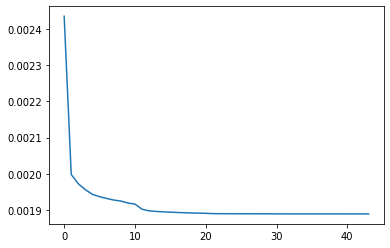

In [31]:
%%time

adata_ae = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata_ae.obs_names = cellinfo.Cell
adata_ae.var_names = geneinfo.Gene

sc.pp.filter_genes(adata_ae, min_counts=1)
data = dca(adata_ae, threads=1, ae_type='mvae',return_info=True,copy=True)
loss = data.uns['dca_loss_history']

import matplotlib.pyplot as plt
plt.plot(loss['loss'])

sc.pp.normalize_per_cell(adata_ae)
sc.pp.log1p(adata_ae)
sc.pp.pca(adata_ae)

## PCA: Simulation with and without dropout effect

... storing 'Batch' as categorical
... storing 'Group' as categorical


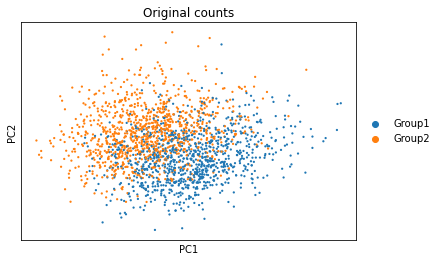

... storing 'Batch' as categorical
... storing 'Group' as categorical


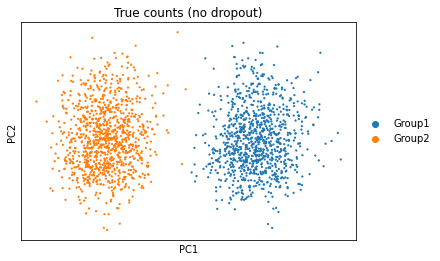

... storing 'Batch' as categorical
... storing 'Group' as categorical


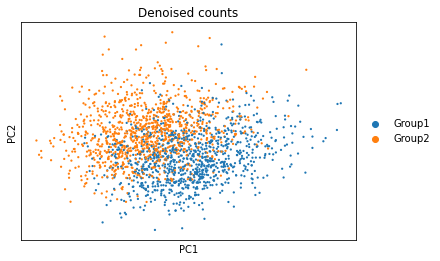

In [32]:
sc.pl.pca_scatter(adata,      color='Group', size=20, title='Original counts')
sc.pl.pca_scatter(adata_true, color='Group', size=20, title='True counts (no dropout)')
sc.pl.pca_scatter(adata_ae,   color='Group', size=20, title='Denoised counts')

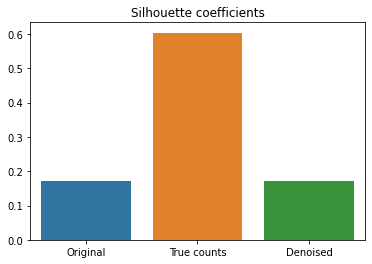

In [33]:
from sklearn.metrics import silhouette_score

sil_orig = silhouette_score(adata.obsm['X_pca'][:, :2],      adata.obs.Group)
sil_true = silhouette_score(adata_true.obsm['X_pca'][:, :2], adata_true.obs.Group)
sil_ae = silhouette_score(adata_ae.obsm['X_pca'][:, :2],     adata_ae.obs.Group)

sns.barplot(x=['Original', 'True counts', 'Denoised'], 
            y=[sil_orig, sil_true, sil_ae])

plt.title('Silhouette coefficients');

In [34]:
adata._sanitize()
adata_ae._sanitize()

In [35]:
adata.obs.Group

Cell
Cell1       Group1
Cell2       Group1
Cell3       Group2
Cell4       Group1
Cell5       Group1
             ...  
Cell1996    Group2
Cell1997    Group2
Cell1998    Group2
Cell1999    Group2
Cell2000    Group1
Name: Group, Length: 2000, dtype: category
Categories (2, object): ['Group1', 'Group2']

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


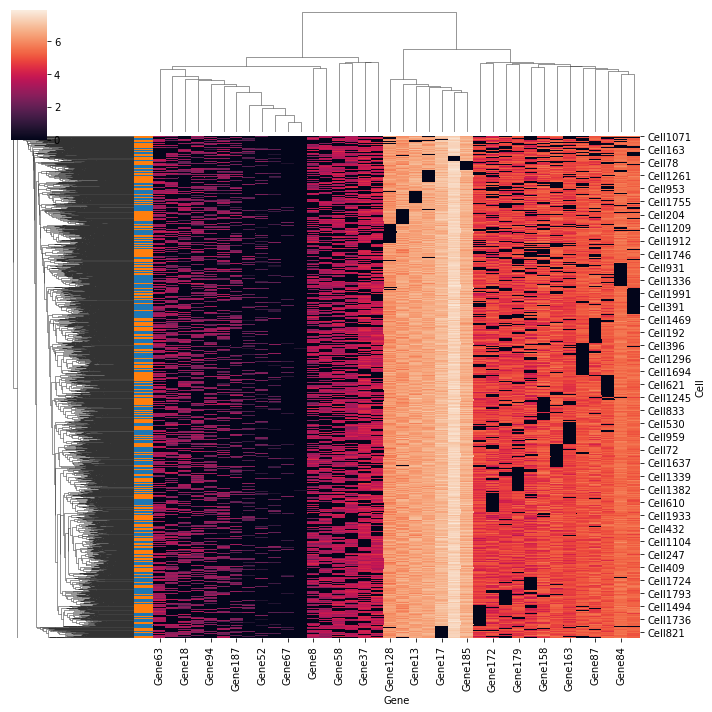

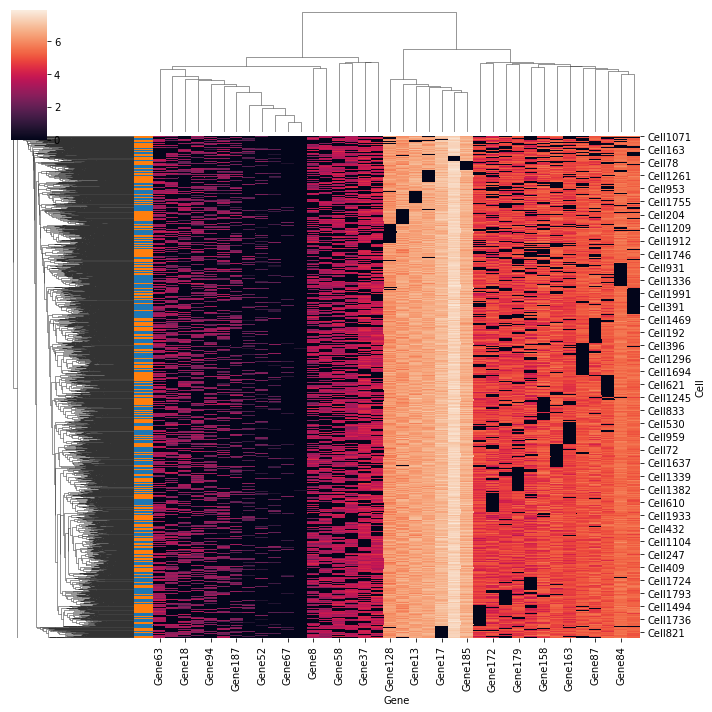

In [36]:
de_genes = (adata.var.loc[:, 'DEFacGroup1':'DEFacGroup2'].values.sum(1) != 2.0)

sc.pl.clustermap(adata[:, de_genes], 'Group', use_raw=False)
sc.pl.clustermap(adata_ae[:, de_genes], 'Group', use_raw=False)

## Simulate six groups

In [37]:
counts     = pd.read_csv('sim_data/data2/counts.csv',     index_col=0)
truecounts = pd.read_csv('sim_data/data2/truecounts.csv', index_col=0)
geneinfo   = pd.read_csv('sim_data/data2/geneinfo.csv',   index_col=0)
cellinfo   = pd.read_csv('sim_data/data2/cellinfo.csv',   index_col=0)

In [38]:
adata = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata.obs_names = cellinfo.Cell
adata.var_names = geneinfo.Gene
sc.pp.filter_genes(adata, min_counts=1)

adata_true = sc.AnnData(truecounts.values, obs=cellinfo, var=geneinfo)
adata_true.obs_names = cellinfo.Cell
adata_true.var_names = geneinfo.Gene
adata_true = adata_true[:, adata.var_names].copy()
adata_true

AnnData object with n_obs × n_vars = 2000 × 198
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6'

In [39]:
sc.pp.normalize_per_cell(adata)
sc.pp.normalize_per_cell(adata_true)

sc.pp.log1p(adata)
sc.pp.log1p(adata_true)

sc.pp.pca(adata)
sc.pp.pca(adata_true)

sc.tl.tsne(adata)
sc.tl.tsne(adata_true)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


## Denoise simulated data

In [40]:
%%time

adata_ae = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata_ae.obs_names = cellinfo.Cell
adata_ae.var_names = geneinfo.Gene

sc.pp.filter_genes(adata_ae, min_counts=1)
dca(adata_ae, threads=1, ae_type='mvae')

sc.pp.normalize_per_cell(adata_ae)
sc.pp.log1p(adata_ae)
sc.tl.tsne(adata_ae)

adata_ae

dca: Successfully preprocessed 198 genes and 2000 cells.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...
         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


CPU times: user 29.1 s, sys: 681 ms, total: 29.8 s
Wall time: 19.7 s


... storing 'Batch' as categorical
... storing 'Group' as categorical


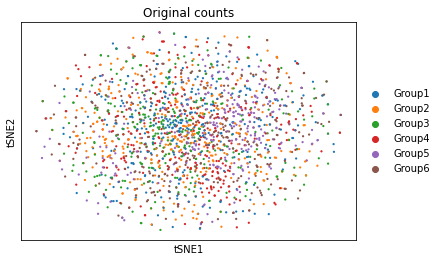

... storing 'Batch' as categorical
... storing 'Group' as categorical


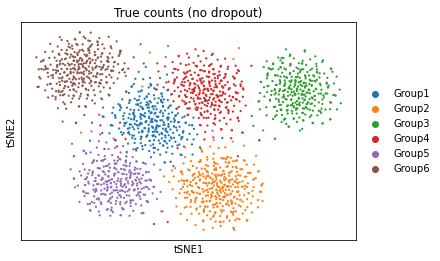

... storing 'Batch' as categorical
... storing 'Group' as categorical


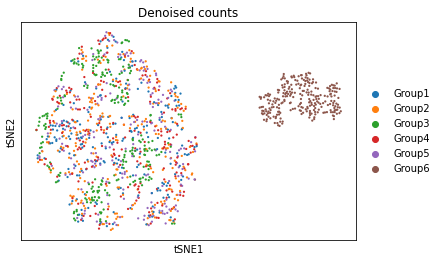

In [41]:
sc.pl.tsne(adata,      color='Group', size=20, title='Original counts')
sc.pl.tsne(adata_true, color='Group', size=20, title='True counts (no dropout)')
sc.pl.tsne(adata_ae,   color='Group', size=20, title='Denoised counts')

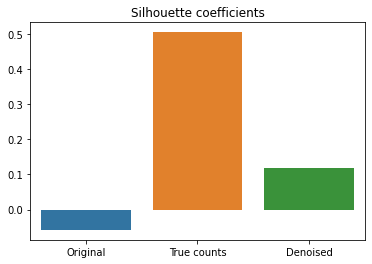

In [42]:
from sklearn.metrics import silhouette_score

sil_orig = silhouette_score(adata.obsm['X_tsne'], adata.obs.Group)
sil_true = silhouette_score(adata_true.obsm['X_tsne'], adata_true.obs.Group)
sil_ae   = silhouette_score(adata_ae.obsm['X_tsne'], adata_ae.obs.Group)

sns.barplot(x=['Original', 'True counts', 'Denoised'], y=[sil_orig, sil_true, sil_ae])
plt.title('Silhouette coefficients');

In [43]:
adata

AnnData object with n_obs × n_vars = 2000 × 198
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'n_counts'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6', 'n_counts'
    uns: 'log1p', 'pca', 'tsne', 'Group_colors'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


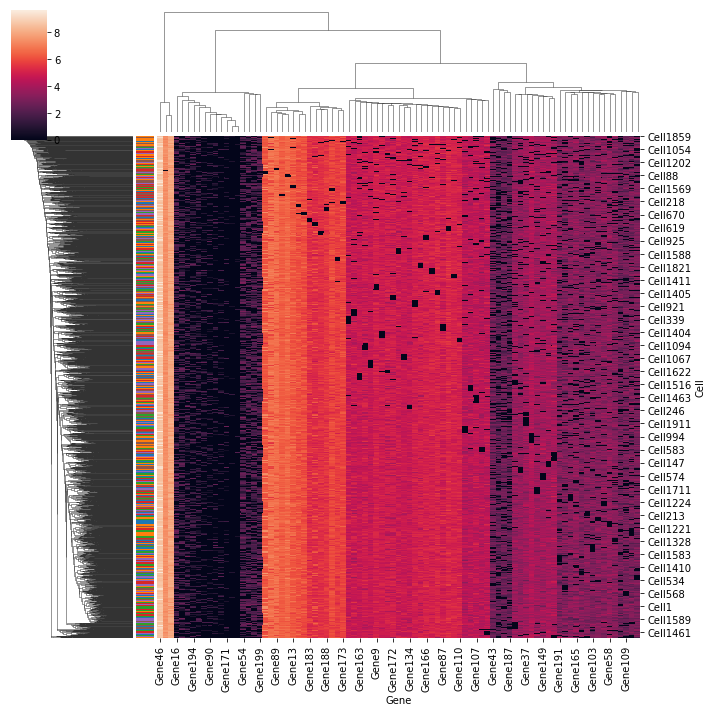

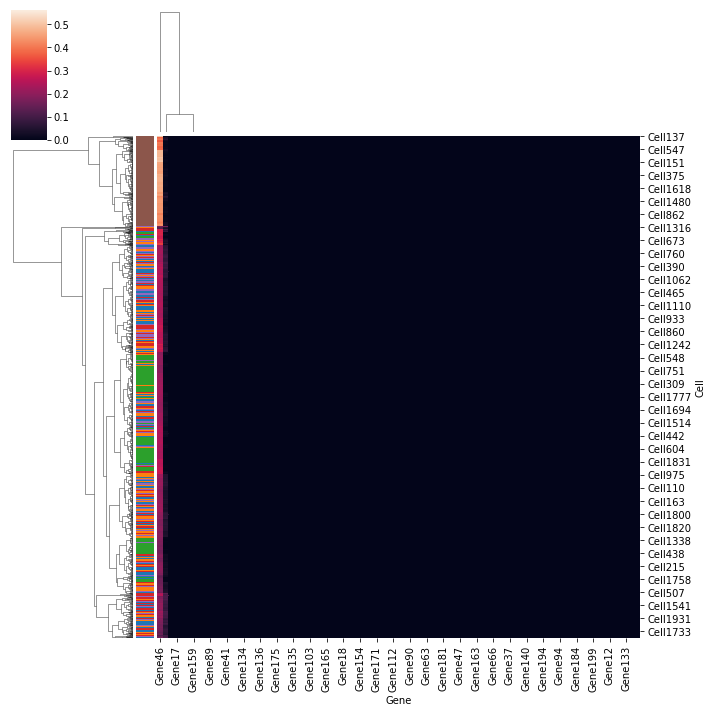

In [44]:
de_genes = (adata.var.loc[:, 'DEFacGroup1':'DEFacGroup6'].values.sum(1) != 6.0)

sc.pl.clustermap(adata[:, de_genes],    'Group', use_raw=False)
sc.pl.clustermap(adata_ae[:, de_genes], 'Group', use_raw=False)